In [1]:
import time
import os

import gymnasium as gym
import numpy as np

#from stable_baselines3 import A2C
from stable_baselines3.common.vec_env import DummyVecEnv, SubprocVecEnv
from stable_baselines3.common.utils import set_random_seed
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3 import SAC
from stable_baselines3 import TD3
from stable_baselines3.common import results_plotter
from stable_baselines3.common.noise import NormalActionNoise
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.callbacks import CheckpointCallback, EveryNTimesteps
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.results_plotter import load_results, ts2xy
from stable_baselines3.common.callbacks import BaseCallback


libEGL warning: failed to open /dev/dri/renderD129: Permission denied

libEGL warning: failed to open /dev/dri/renderD129: Permission denied

libEGL warning: failed to open /dev/dri/renderD128: Permission denied

libEGL warning: failed to open /dev/dri/renderD128: Permission denied



In [2]:
class SaveOnBestTrainingRewardCallback(BaseCallback):
    def __init__(self, check_freq: int, log_dir: str, verbose=1):
        super(SaveOnBestTrainingRewardCallback, self).__init__(verbose)
        self.check_freq = check_freq
        self.log_dir = log_dir
        self.save_path = os.path.join(log_dir, 'best_model')
        self.best_mean_reward = -np.inf
        self.n_calls = 0

    def _on_step(self) -> bool:
        self.n_calls += 1
        if self.n_calls % self.check_freq == 0:
            # Retrieve training reward
            x, y = ts2xy(load_results(self.log_dir), 'timesteps')
            if len(x) > 0:
                # Mean training reward over the last 100 episodes
                mean_reward = np.mean(y[-100:])
                if self.verbose > 0:
                    print(f"Num timesteps: {self.num_timesteps}")
                    print(f"Best mean reward: {self.best_mean_reward:.2f} - Last mean reward per episode: {mean_reward:.2f}")
                # New best model, you could save the agent here
                if mean_reward > self.best_mean_reward:
                    self.best_mean_reward = mean_reward
                    # Example for saving best model
                    if self.verbose > 0:
                        print(f"Saving new best model to {self.save_path}.zip")
                    self.model.save(self.save_path)
        return True


In [3]:
log_dir = '../SAC+HER_Multi-Task_Fetch-PickAndPlace_32-MPI_Testing-V03CL'
env_id = 'FetchPickAndPlace-v2'
num_cpu = 32

vec_env = make_vec_env(env_id, n_envs=num_cpu, monitor_dir=log_dir, vec_env_cls=SubprocVecEnv, seed=9160)
callback = SaveOnBestTrainingRewardCallback(check_freq=1000, log_dir=log_dir)
#model = A2C("MlpPolicy", vec_env, verbose=0)

libEGL warning: failed to open /dev/dri/renderD129: Permission denied

libEGL warning: failed to open /dev/dri/renderD129: Permission denied

libEGL warning: failed to open /dev/dri/renderD128: Permission denied

libEGL warning: failed to open /dev/dri/renderD128: Permission denied

libEGL warning: failed to open /dev/dri/renderD129: Permission denied

libEGL warning: failed to open /dev/dri/renderD129: Permission denied

libEGL warning: failed to open /dev/dri/renderD128: Permission denied

libEGL warning: failed to open /dev/dri/renderD128: Permission denied

libEGL warning: failed to open /dev/dri/renderD129: Permission denied

libEGL warning: failed to open /dev/dri/renderD129: Permission denied

libEGL warning: failed to open /dev/dri/renderD128: Permission denied

libEGL warning: failed to open /dev/dri/renderD128: Permission denied

libEGL warning: failed to open /dev/dri/renderD129: Permission denied

libEGL warning: failed to open /dev/dri/renderD129: Permission denied

libEGL

In [4]:
def env_creator(env_config={}):
    import gymnasium as gym
    env = gym.make('FetchReach-v2', render_mode='rgb_array', reward_type='sparse', max_episode_steps=50)
    #env = SeededFetchReachEnv(env, 960)
    env.reset()
    return env

In [ ]:
from stable_baselines3 import HerReplayBuffer, DDPG, DQN, SAC, TD3
from stable_baselines3.her.goal_selection_strategy import GoalSelectionStrategy
from stable_baselines3.common.envs import BitFlippingEnv

model_class = SAC  # works also with SAC, DDPG and TD3
N_BITS = 15

#env = env_creator({})#BitFlippingEnv(n_bits=N_BITS, continuous=model_class in [DDPG, SAC, TD3], max_steps=N_BITS)

# Available strategies (cf paper): future, final, episode
goal_selection_strategy = "future" # equivalent to GoalSelectionStrategy.FUTURE

# Initialize the model
model = model_class(
    "MultiInputPolicy",
    vec_env,
    replay_buffer_class=HerReplayBuffer,
    # Parameters for HER
    replay_buffer_kwargs=dict(
        #n_envs=4,
        #buffer_size=1000000,
        n_sampled_goal=4,
        goal_selection_strategy=goal_selection_strategy,
    ),
    learning_starts=3500,
    batch_size=256,
    verbose=1,
    learning_rate=0.001,
    #action_noise
    tensorboard_log="../R3L-LOGS/Fetch-PickAndPlace_Multi-Task_32-MPI-TestingV03CL"
)

# Train the model
model.learn(20_000_000, callback=callback)

model.save("./her_Fetch-PickAndPlace_Multi-task_32-MPI_env02-TestingV03CL")
# Because it needs access to `env.compute_reward()`
# HER must be loaded with the env
model = model_class.load("./her_Fetch-PickAndPlace_Multi-task_32-MPI_env02-TestingV03CL", env=env)

obs, info = env.reset()
for _ in range(100):
    action, _ = model.predict(obs, deterministic=True)
    obs, reward, terminated, truncated, _ = env.step(action)
    if terminated or truncated:
        obs, info = env.reset()

Using cuda device
Logging to ../R3L-LOGS/Fetch-PickAndPlace_Multi-Task_32-MPI-TestingV03CL/SAC_2
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 50       |
|    ep_rew_mean     | -50      |
|    success_rate    | 0.0      |
| time/              |          |
|    episodes        | 4        |
|    fps             | 4305     |
|    time_elapsed    | 0        |
|    total_timesteps | 1600     |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 50       |
|    ep_rew_mean     | -50      |
|    success_rate    | 0.0      |
| time/              |          |
|    episodes        | 8        |
|    fps             | 4285     |
|    time_elapsed    | 0        |
|    total_timesteps | 1600     |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 50       |
|    ep_rew_mean     | -50      |
|    success_rate  

/home/lunet/cocp5/anaconda3/envs/R3L-server03/lib/python3.9/site-packages/gymnasium/core.py:297: UserWarning: WARN: env.compute_reward to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.compute_reward` for environment variables or `env.get_attr('compute_reward')` that will search the reminding wrappers.
  logger.warn(


------------------------------------
| rollout/           |             |
|    ep_len_mean     | 50          |
|    ep_rew_mean     | -49         |
|    success_rate    | 0.020833334 |
| time/              |             |
|    episodes        | 68          |
|    fps             | 2524        |
|    time_elapsed    | 1           |
|    total_timesteps | 4800        |
| train/             |             |
|    actor_loss      | -5.45       |
|    critic_loss     | 0.231       |
|    ent_coef        | 0.962       |
|    ent_coef_loss   | -0.262      |
|    learning_rate   | 0.001       |
|    n_updates       | 40          |
------------------------------------
------------------------------------
| rollout/           |             |
|    ep_len_mean     | 50          |
|    ep_rew_mean     | -49         |
|    success_rate    | 0.020833334 |
| time/              |             |
|    episodes        | 72          |
|    fps             | 2521        |
|    time_elapsed    | 1           |
|

In [ ]:
model.learn(500000)

In [ ]:
import gymnasium as gym
#from stable_baselines3 import A2C
from stable_baselines3.common.vec_env import DummyVecEnv, SubprocVecEnv

class RenderOneEnvWrapper(gym.Wrapper):
    def __init__(self, env, env_idx, render_idx):
        super(RenderOneEnvWrapper, self).__init__(env)
        self.env_idx = env_idx
        self.render_idx = render_idx

    def render(self):
        if self.env_idx == self.render_idx:
            return self.env.render()
        return None


def make_env(env_id: str, rank: int, render_idx: int, seed: int = 0):
    """
    Utility function for multiprocessed env.

    :param env_id: (str) the environment ID
    :param num_env: (int) the number of environment you wish to have in subprocesses
    :param seed: (int) the inital seed for RNG
    :param rank: (int) index of the subprocess
    :return: (Callable)
    """

    def _init() -> gym.Env:
        env = gym.make(env_id, render_mode='rgb_array', reward_type='sparse', max_episode_steps=50)
        env.reset(seed=seed + rank)
        env = RenderOneEnvWrapper(env, rank, render_idx)
        return env

    set_random_seed(seed)
    return _init

env_id = "FetchPickAndPlace-v2"
num_envs = 32
render_idx = 0  # Index of the environment you want to render

envs = [make_env(env_id, i, render_idx) for i in range(num_envs)]
vec_env = SubprocVecEnv(envs)

# This will render only the environment with index `render_idx`
vec_env.render()


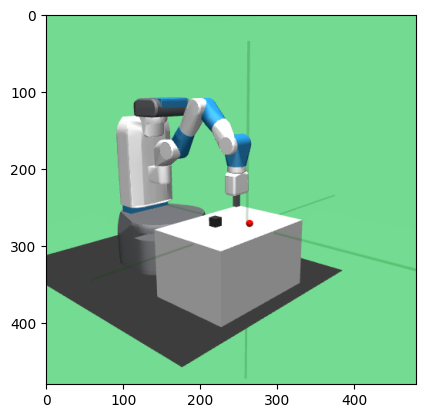

In [6]:
import matplotlib.pyplot as plt
from IPython import display as ipythondisplay

# Get the first environment from the vectorized environments
single_env = env = gym.make(env_id, render_mode='rgb_array', reward_type='sparse', max_episode_steps=50)#vec_env#.envs[0]

obs, info = single_env.reset()

img = plt.imshow(single_env.render())


for _ in range(200):
    action, _ = model.predict(obs, deterministic=True)
    obs, reward, terminated, truncated, _ = single_env.step(action)
    if terminated or truncated:
        obs, info = single_env.reset()
    img.set_data(single_env.render()) # Just update the data
    ipythondisplay.display(plt.gcf())
    ipythondisplay.clear_output(wait=True)
